# Cuff_Less Blood Pressure Estimation:

**Overview:**

<em style='color: red'>Blood pressure (BP)</em>, also referred to as <em style='color: red'>Arterial blood pressure (ABP)</em>, is the pressure exerted by circulating blood upon the walls of blood vessels.


The most common approach to measure Blood Pressure (BP) without clinical supervision is the automated BP cuff employing oscillometry. A cuff is wrapped around the upper arm and inflated above systolic pressure, then deflated to a pressure below diastolic BP. A pressure sensor inserted in the cuff records the arterial pulsations during the cuff deflation, and the amplitudes of these pulsations are used to calculate systolic and diastolic BP. 

<div><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/c6/Blood_pressure_monitoring.jpg/1920px-Blood_pressure_monitoring.jpg", height="100", width="500"/></div>


This approach has many limitations, the primary one being that it relies on a set of empirical coefficients to map the pulse amplitudes to systolic and diastolic BP. Most of these coefficients are specific to the device and can vary across devices. 

Further, since it relies solely on pulse amplitudes, <strong> it fails to provide accurate readings in patients with atherosclerosis or obese patients whose pulse amplitudes can be weak</strong>.

**ElectroCardiogram (ECG)**

ECG or EKG check for signs of heart disease. It's a test that records the electrical activity of your ticker through small electrode patches that a technician attaches to the skin of your chest, arms, and legs.

An abnormal ECG can tell your doctor if you have any of these issues:


1.   irregular heartbeat (an arrhythmia)
2.   problems with the spread of electrical activity within the heart
3.   an enlarged heart
4.   areas of the heart with reduced blood supply
5.   a ‘silent’ heart attack (an interruption to blood flow in the     coronary arteries without usual heart attack symptoms).


<div><img src="https://ecglibrary.com/ecgs/norm_2x.png", height="100", width="500"/></div>

**PhotoPlethysmoGraph (PPG)**

A photoplethysmogram (PPG) is an optically obtained plethysmogram that can be used to detect blood volume changes in the microvascular bed of tissue. A PPG is often obtained by using a pulse oximeter which illuminates the skin and measures changes in light absorption.A conventional pulse oximeter monitors the perfusion of blood to the dermis and subcutaneous tissue of the skin.

A plethysmograph is an instrument for measuring changes in volume within an organ or whole body (usually resulting from fluctuations in the amount of blood or air it contains). 

<div><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/dc/Pulse_oximiter%2C_Photoplethysmograph.jpg/675px-Pulse_oximiter%2C_Photoplethysmograph.jpg", height="50", width="300"/></div>

**The dataset:**

The blood pressure dataset provides clean and valid signals for designing cuff-less blood pressure estimation algorithms. 
The matlab files (.mat) contain raw electrocardiogram (ECG), photoplethysmograph (PPG), and arterial blood pressure (ABP) signals stored as [cell arrays](https://www.mathworks.com/help/matlab/ref/cell.html#:~:text=A%20cell%20array%20is%20a,indices%20in%20smooth%20parentheses%2C%20()%20.) of matrices where each cell is one record part. 
In each matrix, each row corresponds to one signal channel: 

1: PPG signal, FS=125Hz; photoplethysmograph from fingertip 

2: ABP signal, FS=125Hz; invasive arterial blood pressure (mmHg) 

3: ECG signal, FS=125Hz; electrocardiogram from channel II 

Note: Each cell is a record. There might be more than one record per patient (which is not possible to distinguish). However, records of the same patient appear next to each other. 
n-fold cross test and train is suggested to reduce the chance of train set being contaminated by test patients

## Data Analysis

In [1]:
# importing libraries
import numpy as np # For numerical computation
import pandas as pd # Data manipulation
import seaborn as sns # plotting
import scipy.io # reading matlab files in python
from scipy import signal #signal processing
from scipy.fftpack import fft, dct #signal processing

from sklearn.linear_model import LinearRegression #linear regression model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split # cross validation split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt # For plotting graphs(Visualization)

import os # system-wide functions
os.listdir('/kaggle/input/BloodPressureDataset')

['part_5.mat',
 'part_8.mat',
 'part_9.mat',
 'Samples',
 'part_4.mat',
 'part_11.mat',
 'part_2.mat',
 'part_12.mat',
 'part_7.mat',
 'part_3.mat',
 'part_10.mat',
 'part_6.mat',
 'part_1.mat']

In [2]:
# defining our evaluation error function
def rmse(y_true, y_pred):
    """Computes the Root Mean Squared Error (RMSE)."""
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [3]:
sample_file = scipy.io.loadmat(f'../input/BloodPressureDataset/part_{1}.mat')
print(f'sample_file Data type: {type(sample_file)}')
print(f'sample_file keys:\n{sample_file.keys()}')


sample_file Data type: <class 'dict'>
sample_file keys:
dict_keys(['__header__', '__version__', '__globals__', 'p'])


What's happening in the cell above?

* We use the `scipy.io.loadmat()` method to read our sample matlab(.mat) file and store it in the variable `sample_file`
    * The `scipy.io.loadmat()` method reads the matlab file and returns a `dict`/(dictionary) which is then stored back in the `sample_file` variable. To prove this, we print the data type of sample_file `type(sample_file)` as seen in line-2 and bingo it tells us its a `dict`
    
* A [dictionary](https://realpython.com/python-dicts/) is a [data structure](https://en.wikipedia.org/wiki/Data_structure#:~:text=In%20computer%20science%2C%20a%20data,be%20applied%20to%20the%20data.) that stores data in key, value pairs. For instance; {key1: value1, key2: value2}. What line-3 in the cell above does is to get and return the keys of the `sample_file` dictionary.

* Things to try out:
    * try displaying all contents of the `sample file` dictionary to see all its data (hint: just type sample file below the last print statement)
    * display only the values of the `sample file` dictionary (hint: replace `.keys() with .values()`)
    * load any other matlab file by substituting the value 1 with any other in the range (1-12) as there are only 12 files provided.

From  what we've seen above, we only need the values contained in the key `p` (photoplethysmograph or (PPG)). The other keys contain meta data that we won't need.
Therefore in all other cells I'll apply `['p']` at the end of the `.loadmat() method` to only read the values contained in the key `['p']`i.e `scipy.io.loadmat(f'../input/BloodPressureDataset/part_{1}.mat')['p']`

In [4]:
# Loading a sample .mat file to understand the data dimensions
test_sample = scipy.io.loadmat(f'../input/BloodPressureDataset/part_{1}.mat')['p']
print(f'test_sample Data type: {type(test_sample)}')
print(f'test_sample shape/dimensions: {test_sample.shape}')

test_sample Data type: <class 'numpy.ndarray'>
test_sample shape/dimensions: (1, 1000)


In [5]:
## Try printing out the entire array to see its data.


So here's what's happening in the cell above:

* We use the `scipy.io.loadmat()` method to read our sample matlab(.mat) file and store it in the variable `test_sample`
    * The `scipy.io.loadmat()` method reads the matlab file and this time around returns a [numpy ndarray](https://numpy.org/doc/stable/reference/arrays.ndarray.html#:~:text=Quick%20search-,The%20N%2Ddimensional%20array%20(%20ndarray%20),the%20sizes%20of%20each%20dimension.) (because of the `['p']`)  which is then stored in the `test_sample` variable. To prove this, we print the data type of test_sample `type(test_sample)` as seen in line-2 and bingo it tells us its `numpy.ndarray` (nd means n-dimensional)
* Additionally, we check and print the size/dimensions of `test_sample` by running `test_sample.shape` and it prints out `(1,1000)`; <strong> this means the array contains 1 row and 1000 columns.</strong>

Things to try out:

* Load any other matlab file by substituting the value 1 with any other in the range (1-12) and re-run the cell (there are only 12 files provided.). You should get the same shape `(1,1000)`

* Print out the entire `test_sample` array and see what it contains. (Hint: use print(test_sample) or just type test_sample and run the cell). You should see an outer array and multiple inner arrays.i.e all files contain one row and 1000 columns where each column is itself an array.

* Try finding out the contents of each column and the size of each column (hint: accessing nested arrays)

In [6]:
print(f"Total Samples: {len(test_sample[0])}")
print(f"Number of readings in each sample(column): {len(test_sample[0][0])}")
print(f"Number of samples in each reading(ECG): {len(test_sample[0][0][2])}")

temp_mat = test_sample[0, 999]
temp_length = temp_mat.shape[1]
sample_size = 125


print(temp_length)
print((int)(temp_length/sample_size))

Total Samples: 1000
Number of readings in each sample(column): 3
Number of samples in each reading(ECG): 61000
9000
72


In [7]:
sample_size = 125
ppg = []
for i in range(1000):
    temp_mat = test_sample[0, i]
    temp_length = temp_mat.shape[1]
    for j in range((int)(temp_length/sample_size)):
        temp_ppg = temp_mat[0, j*sample_size:(j+1)*sample_size]
        ppg.append(temp_ppg)

<a id='sbp_cell'></a>
In the cell below, I extract BP and ECG signals from the mat file and store them in an array/list.
* I additionally extract Systolic blood pressure(SBP) and Diastolic Blood pressure(DBP) from the BP signal.

* `systole` and `diastole` are two phases of a heart beat. `BP` <strong>increases</strong> as the heart muscle contracts during `systole`, where blood is pushed towards the periphery of the body and it <strong>decreases</strong> when the heart relaxes to fill with blood during the `diastole`. Hence we take `max(BP)` to derive `SBP` and `min(BP)` to get `DBP`. refer to [this paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6696196/) for more insight.

In [8]:
ecg = []
bp = []
sbp = [] #Systolic Blood Pressure
dbp = [] #Diastolic Blood Pressue
size = 125 #sample size

for i in range(1000):
    temp_mat = test_sample[0, i]
    temp_length = temp_mat.shape[1]
    for j in range((int)(temp_length/sample_size)):
        temp_ecg = temp_mat[2, j*size:(j+1)*size]
        temp_bp = temp_mat[1, j*size:(j+1)*size]
        
        max_value = max(temp_bp)
        min_value = min(temp_bp)
        
        sbp.append(max_value)
        dbp.append(min_value)
        ecg.append(temp_ecg)
        bp.append(temp_bp)

In [9]:
# Reshaping the ecg, ppg and bp signal data into column vectors
ppg, ecg, bp = np.array(ppg).reshape(-1,1), np.array(ecg).reshape(-1,1), np.array(bp).reshape(-1,1)
sbp, dbp = np.array(sbp).reshape(-1,1), np.array(dbp).reshape(-1,1)
print(f'PPG_shape: {ppg.shape}\n ECG_shape: {ecg.shape}\n BP_shape: {bp.shape}')
print(f'Systolic-BP_shape: {sbp.shape},\n Diastolic-BP_shape: {dbp.shape}')

PPG_shape: (32061000, 1)
 ECG_shape: (32061000, 1)
 BP_shape: (32061000, 1)
Systolic-BP_shape: (256488, 1),
 Diastolic-BP_shape: (256488, 1)


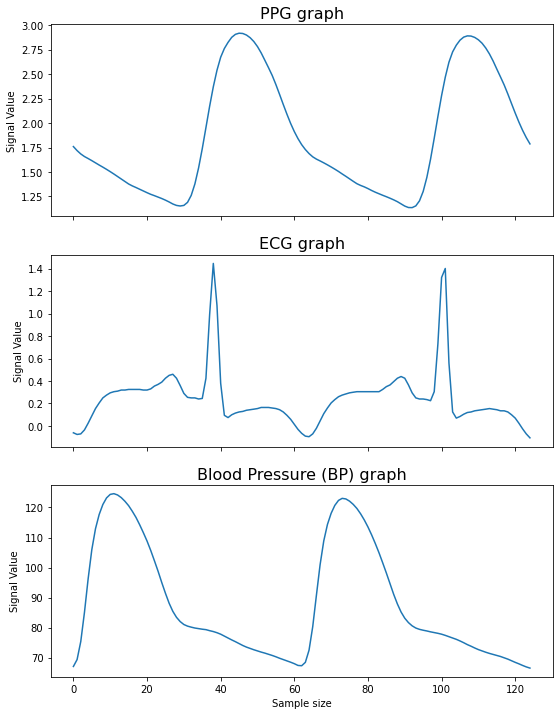

In [10]:
##plotting sample ppg, ecg and bp signals
##using a sample size of 125
fig, ax = plt.subplots(3,1, figsize=(9,12), sharex=True)

ax[0].set_title('PPG graph', fontsize=16)
ax[0].set_ylabel('Signal Value')
ax[0].plot(ppg[:125])

ax[1].set_title('ECG graph', fontsize=16)
ax[1].set_ylabel('Signal Value')
ax[1].plot(ecg[:125])

ax[2].set_title('Blood Pressure (BP) graph', fontsize=16)
ax[2].set_ylabel('Signal Value')
ax[2].set_xlabel('Sample size')
ax[2].plot(bp[:125])

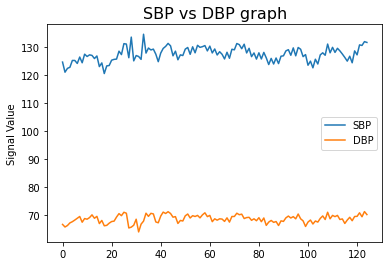

In [11]:
## Visualizing SBP and DBP
#fig, ax = plt.subplots(1,1, figsize=(9,12))

plt.title('SBP vs DBP graph', fontsize=16)
plt.ylabel('Signal Value')
plt.plot(sbp[:125])
plt.plot(dbp[:125])
plt.legend(['SBP', 'DBP'])

It can be seen from above that `SBP` is higher than `DBP` as was explained [earlier](#sbp_cell)

### Statistical Correlation of signals


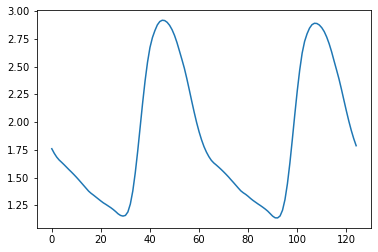

In [12]:
plt.plot(ppg[:125].squeeze())

### Computing and Visualizing the Cross correlation of PPG and BP signals

[Cross correlation](https://en.wikipedia.org/wiki/Cross-correlation#:~:text=In%20signal%20processing%2C%20cross%2Dcorrelation,for%20a%20shorter%2C%20known%20feature.) is where two signals are compared inorder to produce a third signal that shows the similarity between the two signals compared. It can be used to create plots that may reveal hidden sequences.

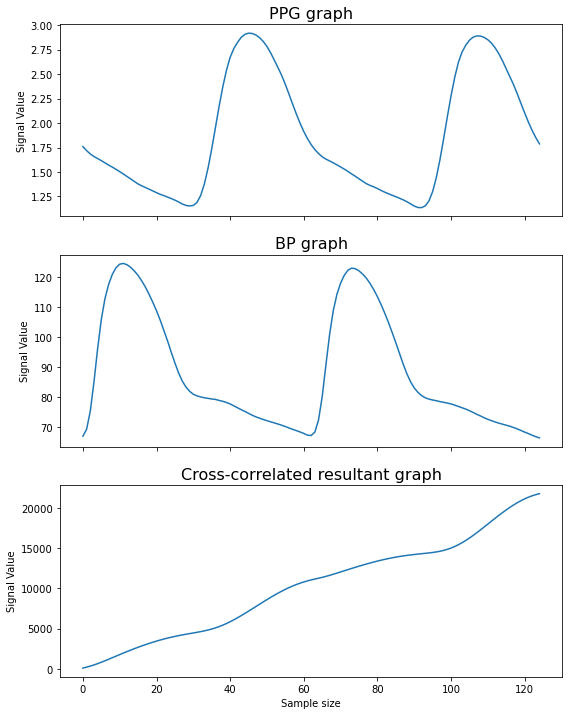

In [13]:
# Computing the cross correlation of ppg and bp signals
cross_corr = np.convolve(ppg[:125].squeeze(), bp[:125].squeeze(), mode='full')

fig, ax = plt.subplots(3,1, figsize=(9,12), sharex=True)

ax[0].set_title('PPG graph', fontsize=16)
ax[0].set_ylabel('Signal Value')
ax[0].plot(ppg[:125])

ax[1].set_title('BP graph', fontsize=16)
ax[1].set_ylabel('Signal Value')
ax[1].plot(bp[:125])

ax[2].set_title('Cross-correlated resultant graph', fontsize=16)
ax[2].set_ylabel('Signal Value')
ax[2].set_xlabel('Sample size')
ax[2].plot(cross_corr[:125])

### Are PPG signals Discrete Cosine Transform (DCT) of BP signals

Lets assume that `BP` is `dct(PPG)` or that `BP` is a discrete cosine transform of PPG and try to prove this hypothesis using the root mean squared error as our evaluation function.

In [14]:
#Computing the discrete cosine transform (DCT)
cosine_transformed_array = dct(ppg)
error = rmse(bp.squeeze(), cosine_transformed_array.squeeze())
print(f'RMSE: {error}')

RMSE: 92.6029607182544


The error margin is too big so our assumption can't be True

## Machine Learning Model Training:
### Approach 1: [linear regression model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

I'll train a simple linear regression model on `ppg signals` with `bp` as my target variable (you may add `ecg` too but I'll only focus on `bp`.
I'll split the data into train and test sets and further split the train set using KFold splits into train and validation sets.

In [15]:
# creating train and test sets
X_train, X_test, y_train, y_test = train_test_split(ppg, bp, test_size=0.30)

In [16]:
#Kfold cross-validation
folds = KFold(n_splits=5, shuffle=False)
scores = []
for i, (train_index, val_index) in enumerate(folds.split(X_train, y_train)):
    train_data, target = X_train[train_index], y_train[train_index]
    validation_data, val_target = X_train[val_index], y_train[val_index]
    
    model = LinearRegression()
    model.fit(train_data, target)
    #model = RandomForestRegressor(n_estimators=50,max_depth=5, n_jobs=-1, random_state=42)
    #model.fit(train_data[:100000], target[:100000].squeeze())  # training on few samples to save time.
    val_predictions = model.predict(validation_data)
    error = rmse(val_target, val_predictions)
    scores.append(error)
    print(f'Fold {i} RMSE: {error}')
print(f'Average RMSE over 5 folds: {np.mean(scores)}')

Fold 0 RMSE: 27.348154011973293
Fold 1 RMSE: 27.339339955815156
Fold 2 RMSE: 27.340857849050785
Fold 3 RMSE: 27.351274605024994
Fold 4 RMSE: 27.336617979464293
Average RMSE over 5 folds: 27.34324888026571


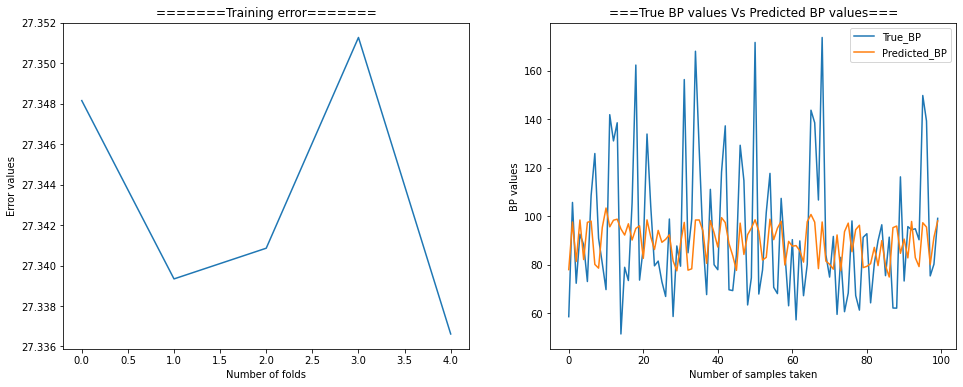

In [17]:
# Visualizing train error.
fig, ax = plt.subplots(1,2, figsize=(16,6))
ax[0].set_title("=======Training error=======")
ax[0].set_xlabel('Number of folds')
ax[0].set_ylabel('Error values')
ax[0].plot(scores)

# Visualize predicted BP and the True BP
ax[1].set_title("===True BP values Vs Predicted BP values===")
ax[1].set_xlabel('Number of samples taken')
ax[1].set_ylabel('BP values')
ax[1].plot(val_target[:100]) #only plotting 100 samples
ax[1].plot(val_predictions[:100])
ax[1].legend(['True_BP', 'Predicted_BP'])

In [18]:
# Predicting on the test set
test_predictions = model.predict(X_test[:1000000]) #predicting on the first 1million rows for speed.
test_error = rmse(y_test[:1000000], test_predictions)
print(f'Error on test set predictions: {test_error}')

Error on test set predictions: 27.3570198799599


Our test and validation errors are within the same range.

Things to try out:

* Predict ecg from ppg instead of bp. (Hint: replace bp with ecg in the cell that has `train_test_split(...)`)
* Experiment with other machine learning models to reduce the error to below `27` for example comment out the `model = LinearRegression()` and the next `model.fit` line and uncomment the commented code to see the improvement

## Predicting Blood Pressure using Deep Learning

For more resource about deep learning,[VISIT this site](https://www.tensorflow.org/tutorials/keras/regression)

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

In [20]:
def Model(input_dim, activation, num_class):
    model = Sequential()

    model.add(Dense(1024, input_dim = input_dim))
    model.add(Activation(activation))
    model.add(Dropout(0.5))

    model.add(Dense(512)) 
    model.add(Activation(activation))
    model.add(Dropout(0.5))

    model.add(Dense(64))    
    model.add(Activation(activation))
    model.add(Dropout(0.25))

    model.add(Dense(num_class))    
    model.add(Activation('linear'))
    
    model.compile(loss='Huber',
                  optimizer=optimizers.Adam(lr = 0.001),
                  metrics=['MeanAbsoluteError']
                 )
    return model

In [21]:
input_dim = X_train.shape[1]
activation = 'relu'
classes = 1
model = Model(input_dim=input_dim, activation=activation, num_class=classes)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              2048      
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                3

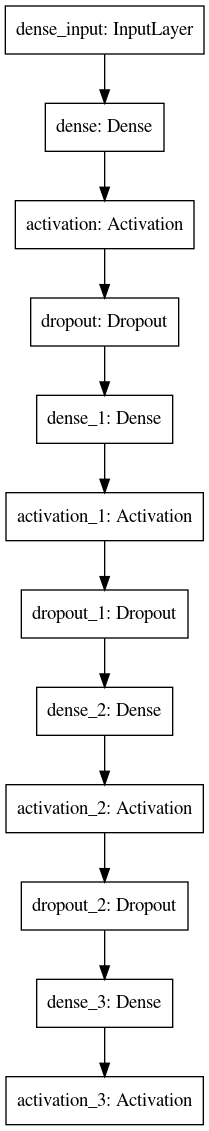

In [22]:
# Visualizing the model
tf.keras.utils.plot_model(model)

In [23]:
# Training the model
history = model.fit(X_train[:1000000], # using the first 1million rows for speed.
                    y_train[:1000000].squeeze(),
                    epochs=5,
                    batch_size=128,
                    verbose = 1
                   )

Epoch 1/5
7813/7813 [==============================] - 21s 3ms/step - loss: 22.2207 - mean_absolute_error: 22.7156
Epoch 2/5
7813/7813 [==============================] - 22s 3ms/step - loss: 20.6333 - mean_absolute_error: 21.1277
Epoch 3/5
7813/7813 [==============================] - 21s 3ms/step - loss: 20.4318 - mean_absolute_error: 20.9260
Epoch 4/5
7813/7813 [==============================] - 21s 3ms/step - loss: 20.2678 - mean_absolute_error: 20.7621
Epoch 5/5
7813/7813 [==============================] - 22s 3ms/step - loss: 20.1115 - mean_absolute_error: 20.6056


In [24]:
#Predicting on the test set using the nn(neural network) model
nn_predictions = model.predict(X_test[:1000000])
error = rmse(y_test[:1000000], nn_predictions)
print(f'Neural Net RMSE: {error}')

Neural Net RMSE: 25.886208065418522


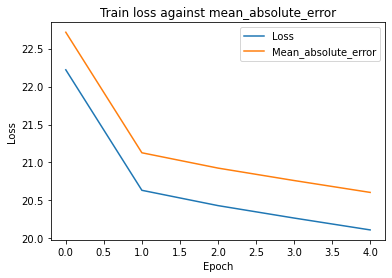

In [25]:
plt.title('Train loss against mean_absolute_error')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(history.history['loss'])
plt.plot(history.history['mean_absolute_error'])
plt.legend(['Loss', 'Mean_absolute_error'])

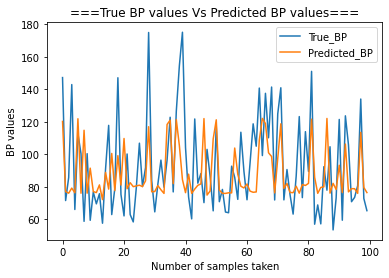

In [26]:
# Visualize predicted BP and the True BP
plt.title("===True BP values Vs Predicted BP values===")
plt.xlabel('Number of samples taken')
plt.ylabel('BP values')
plt.plot(y_test[:100]) #only plotting 100 samples
plt.plot(nn_predictions[:100])
plt.legend(['True_BP', 'Predicted_BP'])

### Use this kernel as inspiration to dive deeper into some topics you find interesting
